## The problem

The problem I am proposing is the prediction of civilian death in conflicts in regions in Ethiopia.
I formulate the problem as a binary classification problem, given details of a conflict, an event, 

civilian death recorded = 1

civilian death not recorded = 0

### Dataset and preprocessing 

#### To align the execrcise with both CARSA, my country and background, I intentionally searched for a valid dataset and thus decided to work on the Ethiopian conflict dataset from https://data.humdata.org/dataset/ucdp-data-for-ethiopia?force_layout=desktop

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from datetime import date

In [2]:
df = pd.read_csv('conflict_data_eth.csv')
df.head()

,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnoa,gwnob
0,NaN,NaN,#date+year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,#date+end,NaN,NaN,NaN,NaN,#affected+killed,NaN,NaN,NaN,NaN
1,370840.0,ETH-2020-1-555-0,2020,1.0,Clear,1.0,267.0,267.0,Ethiopia: Government,555.0,...,2020-11-04 00:00:00.000,200.0,0.0,0.0,0.0,200,200.0,200.0,530.0,NaN
2,371338.0,ETH-2020-1-555-19,2020,1.0,Clear,1.0,267.0,267.0,Ethiopia: Government,555.0,...,2020-11-04 00:00:00.000,0.0,0.0,0.0,3.0,3,3.0,2.0,530.0,NaN
3,371058.0,ETH-2020-1-555-9,2020,1.0,Clear,1.0,267.0,267.0,Ethiopia: Government,555.0,...,2020-11-11 00:00:00.000,2.0,0.0,0.0,0.0,2,2.0,2.0,530.0,NaN
4,370947.0,ETH-2020-1-555-6,2020,1.0,Clear,1.0,267.0,267.0,Ethiopia: Government,555.0,...,2020-11-09 00:00:00.000,0.0,0.0,0.0,1.0,1,500.0,0.0,530.0,NaN


In [3]:
df.columns

Index(['id', 'relid', 'year', 'active_year', 'code_status', 'type_of_violence',
       'conflict_dset_id', 'conflict_new_id', 'conflict_name', 'dyad_dset_id',
       'dyad_new_id', 'dyad_name', 'side_a_dset_id', 'side_a_new_id', 'side_a',
       'side_b_dset_id', 'side_b_new_id', 'side_b', 'number_of_sources',
       'source_article', 'source_office', 'source_date', 'source_headline',
       'source_original', 'where_prec', 'where_coordinates',
       'where_description', 'adm_1', 'adm_2', 'latitude', 'longitude',
       'geom_wkt', 'priogrid_gid', 'country', 'iso3', 'country_id', 'region',
       'event_clarity', 'date_prec', 'date_start', 'date_end', 'deaths_a',
       'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best', 'high', 'low',
       'gwnoa', 'gwnob'],
      dtype='object')

#### Taking into condsideration the description of the dataset, I decided to let go a couple of the columuns 

The full description of the dataset can be found here https://data.humdata.org/dataset/ucdp-data-for-ethiopia?force_layout=desktop

###### Decided to add the duration of the conflict as a feature as I remove the start and end dates.

In [4]:
df=df.drop([0])

In [5]:
def Duration(d1, d2):
    d1=d1[:10]
    d2=d2[:10]

    d1 = date(int(d1[:4]), int(d1[5:-3]), int(d1[-2:]))

    d2 = date(int(d2[:4]), int(d2[5:-3]), int(d2[-2:]))

    if d2 > d1:  
        return (d2-d1).days
    else:
        return (d1-d2).days


In [6]:
duration=[] 

for i,j in zip(df['date_start'].values,df['date_end'].values):
    duration.append(Duration(i,j))

In [7]:
df['duration']=duration

In [ ]:
# y=list(1*(df['deaths_civilians'].values>0))

In [8]:
df=df.drop([
    'longitude', 'latitude','id','geom_wkt','gwnoa',
         'where_prec','where_description','where_coordinates','conflict_new_id','gwnob',
         'country','iso3','country_id','region','code_status',
            'source_office','source_date','source_headline','source_office','source_original',
           'dyad_dset_id', 'dyad_new_id','side_a_dset_id','side_a_new_id','conflict_dset_id','priogrid_gid',
        'side_b_dset_id','side_b_new_id',
    'source_article','number_of_sources','conflict_name',
    'date_prec','event_clarity','year',
    'date_start','date_end', 'high','low','best','dyad_name','relid'
], axis=1)

#### I choose to remove the row with missing values. 

In [9]:
df = df.dropna() 
y=list(1*(df['deaths_civilians'].values>0))
# y=df['deaths_civilians']
df=df.drop([ 'deaths_civilians'], axis=1)

In [10]:
df['label']=y

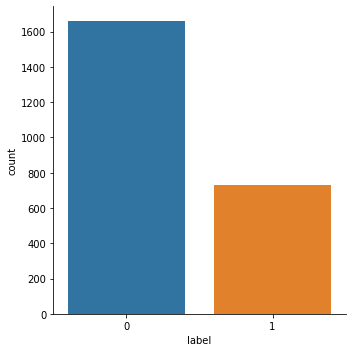

In [11]:
# Explore Target distribution 
sns.catplot(x="label", kind="count", data=df)

### There is class imbalance between the two classes

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2390 entries, 1 to 2903
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   active_year       2390 non-null   float64
 1   type_of_violence  2390 non-null   float64
 2   side_a            2390 non-null   int64  
 3   side_b            2390 non-null   int64  
 4   adm_1             2390 non-null   int64  
 5   adm_2             2390 non-null   int64  
 6   deaths_a          2390 non-null   float64
 7   deaths_b          2390 non-null   float64
 8   deaths_unknown    2390 non-null   float64
 9   duration          2390 non-null   int64  
dtypes: float64(5), int64(5)
memory usage: 269.9 KB


#### transform the data into suitable format

In [19]:
# Cobvert target label to numerical Data
le = LabelEncoder()

df["side_b"] = le.fit_transform(df["side_b"])
df["side_a"] = le.fit_transform(df["side_a"])

df["adm_1"] = le.fit_transform(df["adm_1"])
df["adm_2"] = le.fit_transform(df["adm_2"])

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df)

In [20]:
data

array([[1.        , 0.        , 0.62162162, ..., 0.        , 0.        ,
        0.00273973],
       [1.        , 0.        , 0.62162162, ..., 0.        , 0.003     ,
        0.00273973],
       [1.        , 0.        , 0.62162162, ..., 0.        , 0.        ,
        0.01917808],
       ...,
       [1.        , 1.        , 0.59459459, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.59459459, ..., 0.        , 0.        ,
        0.02191781],
       [1.        , 0.5       , 0.05405405, ..., 0.        , 0.05      ,
        0.00273973]])

In [21]:
len(y),data.shape

(2390, (2390, 10))

In [22]:
X_Train, X_Val, y_Train, y_val = train_test_split(data, y, test_size = 0.2, random_state=42)

### Pre processing completed, and model building 

## Using Neural Networks

In [51]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch import optim

import random
def seed_all(seed):
    if not seed:
        seed = 10
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_all(1)

#### Dataset and data loader

In [55]:
class Data(Dataset):
    def __init__(self, x, y):
        self.x=x
        self.y=y
            
    def __getitem__(self, i):
        y=self.y[i]
        x= self.x[i]
        return x,y

    def __len__(self):
        return len(self.x)
    
bs=64

train_loader = torch.utils.data.DataLoader(dataset=Data(X_Train,y_Train), batch_size=bs)
test_loader = torch.utils.data.DataLoader(dataset=Data(X_Val,y_val), batch_size=bs,shuffle=False)

## Define a Neural Network model

In [57]:
class Model(torch.nn.Module):
    def __init__(self, n_features):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(n_features, 50)
        self.layer2= nn.Linear(50, 30)
        self.layer3= nn.Linear(30, 10)
        self.out = nn.Linear(10, 1)
        self.dropout_1 = nn.Dropout(.3) 
        self.dropout_2 = nn.Dropout(.1) 

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout_1(x)
        x = F.relu(self.layer2(x))
        x = self.dropout_2(x)
        x = F.relu(self.layer3(x))
#         x=self.layer3(x)
        x=self.out(x)
        x= torch.sigmoid(x)
        return x
    
in_features=(X_Train.shape[1])

## Choosing appropriate loss function, optimizer, learning rate,  ...


### SGD optimizer performed worse, then selected Adam
### Binary cross entropy is a suitable loss function for the problem
### I started with few epoches, then escalated to 1000 ...which worked better

In [108]:

lr=.00001
model=Model(in_features)
optimizer=optim.Adam(model.parameters(), lr=lr)


criterion = nn.BCELoss()
epoches=100

### Train

In [70]:
epoches=1000
for epoch in range(epoches):
    for inputs, target in train_loader:
#     for in
        optimizer.zero_grad()
        y_pred=model(torch.tensor(inputs).float())  

        label=torch.unsqueeze(torch.tensor(target).float(), dim=1)
        loss = criterion(y_pred, label)

        loss.backward()
        optimizer.step()
    if epoches%100==100:
        print(loss.item())


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### test

In [73]:
model.eval()

Model(
  (layer1): Linear(in_features=10, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=30, bias=True)
  (layer3): Linear(in_features=30, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
  (dropout_1): Dropout(p=0.3, inplace=False)
  (dropout_2): Dropout(p=0.1, inplace=False)
)

In [97]:
pred_nn=model(torch.tensor(test_loader.dataset.x).float())
sum(np.array(1*(pred_nn.squeeze()>0.5))==np.array(test_loader.dataset.y))/len(test_loader.dataset.y)

0.9288702928870293

#### The neural network model achived 92.8 \%

# ## How can we optimizer it ? Can we use Neural Networks

### There are many ways but here I try to show how regularization can help in performance improvment even when the number of epoches is halved. This saves time while increasing performance.

In [122]:
model=Model(in_features)
lr=.001
optimizer=optim.Adam(model.parameters(), lr=lr)
epoches=500

model.train()

for epoch in range(epoches):
    for inputs, target in train_loader:
#     for in
        optimizer.zero_grad()
        y_pred=model(torch.tensor(inputs).float())  

        label=torch.unsqueeze(torch.tensor(target).float(), dim=1)
        loss = criterion(y_pred, label)
        
        
        l2_lambda = 0.001     # hyperparameters for regularization
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())


        loss = loss + l2_lambda * l2_norm

        loss.backward()
        optimizer.step()
    if epoches%100==100:
        print(loss.item())

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [123]:
pred_nn=model(torch.tensor(test_loader.dataset.x).float())
sum(np.array(1*(pred_nn.squeeze()>0.5))==np.array(test_loader.dataset.y))/len(test_loader.dataset.y)

0.9309623430962343

### As it can be seen, the regularization increase the performance of the NN model

# Explainablity phase using SHAP


For explainability, I will use shap because it is model agnostice and suitable for such tabular data. 

In [98]:
import shap

In [101]:
explainer = shap.DeepExplainer(model,torch.tensor(train_loader.dataset.x).float())
shap_values = explainer.shap_values(torch.tensor(test_loader.dataset.x).float())

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


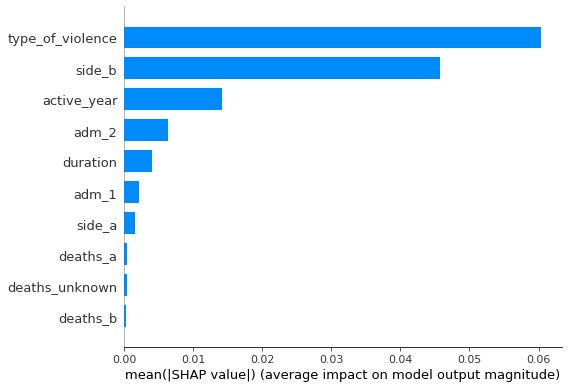

In [107]:
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = list(df.columns.values))

## Discussion 

The attribution above shows that the important features the model used to decide whather there will be a fatality of civilians 
or not. The top four are the most important features according to the shap algorithm. This information can be utlized for decision making in the context of applying the model for resouce/ aid allocation. Further, if the model is turned in to a regression model so that it can show the number of the actual number of fatalities, it becomes much more useful. Addiontally, future conflicts can be addressed by looking at early signs of these attributes.



## One way to do a good decision support research is to traingulate. So, now I try to use a tree algorithm

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

random_forest_model=clf = RandomForestClassifier( max_depth = 4, max_features = 3, bootstrap = True, random_state = 18)

random_forest_model.fit(X_Train, y_Train)

y_pred = clf.predict(X_Val)

print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_val, y_pred)))


Model accuracy score with 10 decision-trees : 0.9393


### Interpreting the tree based model

In [119]:
feature_scores = pd.Series(random_forest_model.feature_importances_, index=df.columns).sort_values(ascending=False)

print(feature_scores)

side_b              0.420733
type_of_violence    0.398402
adm_1               0.084098
deaths_unknown      0.029985
adm_2               0.018925
duration            0.013662
deaths_a            0.011060
side_a              0.010330
active_year         0.009802
deaths_b            0.003004
dtype: float64


##### A key difference between the two explanations/ model interpretaions is that there is a slight difference between attrubutions. But the top attributes (side_b, and type_of_violence) are informative of the weather or not there will be a civilian life loss in a conflict.

In [121]:
cm = confusion_matrix(y_val, y_pred)
print('Confusion matrix\n\n', cm)


from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

Confusion matrix

 [[320   4]
 [ 25 129]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       324
           1       0.97      0.84      0.90       154

    accuracy                           0.94       478
   macro avg       0.95      0.91      0.93       478
weighted avg       0.94      0.94      0.94       478



# Key take aways

#### The data provided can be used by ML algorithm for public policy usage
#### Potential bias might arise from places where there might have been less data
#### The attributions can be slightly different from model to model.
#### In a real world situation, this can be used for good but this same data can be exploited by external forces